# FinalCapstone_5_Analysis

This is a notebook that contains the analysis for the first part of "What is the best neighbourhood to live in as a student at Imperial College London?" (*link:* https://github.com/namiyousef/Coursera_Capstone).

**NOTE:** if you are a peer examiner from the IBM Coursera course (IBM Applied Data Science Capstone), please only mark this notebook, and the relevant parts of the report. At this current time, I will not be able to complete the second part of the project (stated in my report).

Note that the scope of this project was far greater than that required by the IBM Course, in particular with regards to the volume of data. The previous notebooks deal with different data sources and reach the conclusion that **crime** and **demographics** cannot be considered as part of the analysis, as initially stated on the project proposal.

With that in mind, this notebook contains the data exploration and cleaning, modelling and evaluation.

**Structure of the notebook:**
0. Libraries needed, configuration
1. Data attainment, cleaning and exploration
2. Data visualisation
3. Modelling
4. Evaluation
5. Final results
6. Conclusion

# 0 - Libraries needed, configuration

In [109]:
""" Libraries """

# file management and web scraping

#import os
import urllib.request
import requests
#try: 
  #  from BeautifulSoup import BeautifulSoup
#except ImportError:
 #   from bs4 import BeautifulSoup

import json

# mathematical
from math import radians, sin, cos, atan2, sqrt

# data exploration
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

# visualisation
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.cm as cm
import folium
from geopy.geocoders import Nominatim # NOTE: nominatim is not great, googleV3 is much better
from geopy.geocoders import GoogleV3



# preprocessing
from sklearn.preprocessing import MinMaxScaler

# modelling
from sklearn.cluster import KMeans

# evaluation

""" Configuration """

# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)



# matplotlib
plt.style.use('classic')

# 1. Data Attainment, Cleaning and Exploration

## Cleaning rent data

In [4]:
df_rent = pd.read_csv('../Data/dataframes/df_rent.csv',index_col = 0)
# the data for df_rent has attained from rentbarometer in the FinalCapstone_1_ClusteringNeighbourhoods where web 
# sraping was used (using the BeautifulSoup library)

In [5]:
df_rent.head()

,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist,latitude,longitude
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1,51.415207,0.029229
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0,51.362729,-0.064208
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2,51.528134,-0.061651
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3,51.528148,-0.020542
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14,51.509750,-0.017595


In [6]:
# for the sake of not breaking code

df_rent_original = df_rent

df_rent = df_rent.drop(['latitude','longitude'],axis =1)

As seen above, there are many NaN values. Instead of removing these, let's replace them with either the mean or median values. For this, we need to see the distributions of prices in each column first!

6


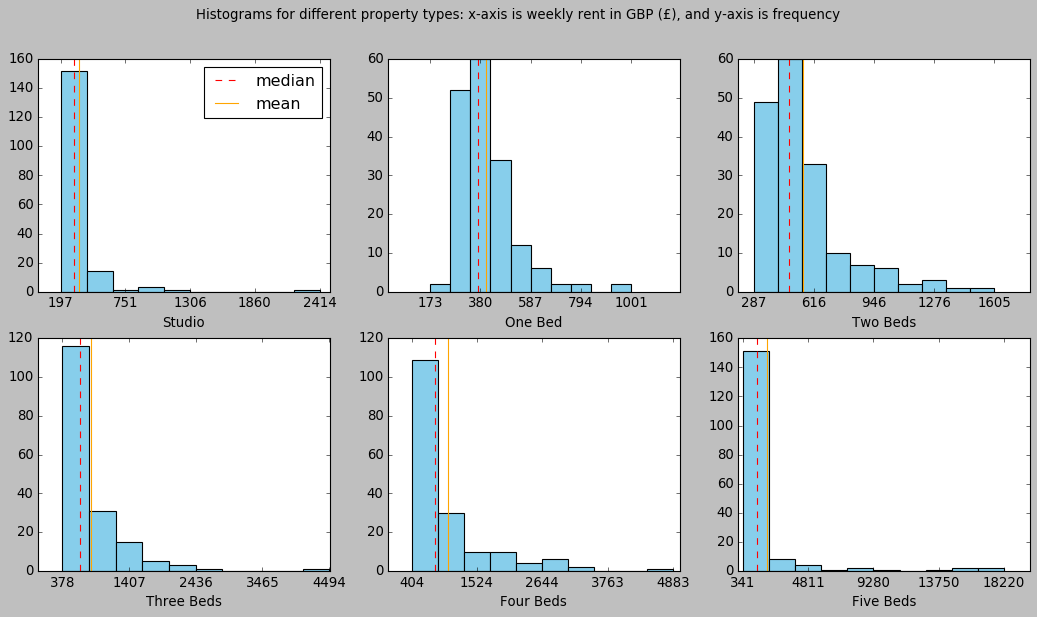

In [7]:
columns = df_rent.columns.values.tolist()[1:-1]
print(len(columns))
fig = plt.figure(figsize = (16,8))
plt.suptitle('Histograms for different property types: x-axis is weekly rent in GBP (£), and y-axis is frequency')
for index,column in enumerate(columns):
    fig.add_subplot(2,3,index+1)
    df_temp = df_rent[column]
    df_temp.dropna(axis = 0,inplace = True)
    plt.hist(df_temp,color = 'skyblue')
    plt.axvline(x = df_temp.median(),linestyle = '--',color = 'r')
    plt.axvline(x = df_temp.mean(),linestyle = '-',color = 'orange')
    plt.xticks(np.linspace(df_temp.min(),df_temp.max(),5))
    if index == 0:
        plt.legend(['median','mean'])
    plt.xlabel(column)

Seeing as for for the most part, the median seems to be more reliable... it was decidecd to replace the np.nan values with the median!

In an ideal case, one would first, as part of the preprocessing, ensure that neighbourhoods are first clustered by the average property prices (i.e. cheaper ones would be clustered together, more expensive ones in another cluster, then for each cluster, the median will be used to fill that certain cluster). This would be interesting to add for the next iteration of this project.

In [8]:
for i, column in enumerate(columns):
    df_rent[column] = df_rent[column].fillna(df_rent[column].median())

df_rent.head()




,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14


## Finding close supermarkets, restaurants and nightlife

In [66]:
# path to .json file containing Foursquare credentials

path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/config.json")

with open(path, 'r') as f:
    config = json.load(f)

# configure the foursquare API rules
CID = config['foursquare']['CID']
CSecret = config['foursquare']['CSecret']
CategoryID = '4d4b7105d754a06374d81259'
version = '20180604'
limit = 50 # maximum limit allowed by foursquare [1]
latitude = '50'
longitude = '-0.1'

# setting up a query for formatting the foursquare URL
query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

# categories that we are interested in searching, with their correct foursquare ID's [2]
categories = {
    'restaurants':'4d4b7105d754a06374d81259',
    'grocery': '4bf58dd8d48988d1f9941735',
    'nightlife': '4d4b7105d754a06376d81259',
    'entertainment': '4d4b7104d754a06370d81259',
    'outdoors': '4d4b7105d754a06377d81259'
}

# testing that everything works
url = ('https://api.foursquare.com/v2/venues/search?client_id={CID}'
       '&client_secret={CSecret}'
       '&categoryId={CategoryID}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      )

url_test = url.format(**query)

In [64]:
#ideally, you should convert all of these into a class ! 

def plot_map(lat_long,geojson_path):
    m = folium.Map(
        location = lat_long, # must be a list
        zoom_start = 11,
        no_touch = True,
        tiles = 'CartoDB positron'
    )
    folium.GeoJson(
    geojson_path,
    name='geojson'
    ).add_to(m)
    
    return m

def add_labels(geolocator, m, address_list, address_global = ''):
    for index, address in enumerate(address_list):
        try:
            
            lat_long = get_lat_long(geolocator, address+', {}'.format(address_global))
            if lat_long != None:
                folium.Marker(
                    location = lat_long
                ).add_to(m)
        except:
            pass

        print(index/len(address_list))
    return m
    
def get_lat_long(geolocator,address):
    # note, geolocator must be defined before

    location = geolocator.geocode(address)
    return [location.latitude, location.longitude]

# note that the above, using NOMINATIM as a geocoder is terrible !

def add_labels1(geolocator, m, address_list, locality, country):
    for index, address in enumerate(address_list):


        lat_long = get_lat_long1(geolocator, address, locality, country)
        if lat_long != None:
            icon = folium.features.CustomIcon(icon_image='http://clipart-library.com/image_gallery/81095.png',
                                              icon_size=(30,30))
            folium.Marker(
                location = lat_long,
                popup = address,
                #icon=folium.Icon(color='blue',prefix='fa',icon='map-pin'),
                #icon = folium.DivIcon(html = '<div>{}</div>'.format(address))
                icon = icon
            ).add_to(m)
    return m
    
def get_lat_long1(geolocator,address,locality,country):
    # note, geolocator must be defined before

    try:
        location = geolocator.geocode(query=address, components = {'country':country,"locality":locality})
    except:
        pass
    if location != None:
        return [location.latitude, location.longitude]
    else:
        return None





In [12]:
#geolocator = Nominatim(user_agent="foursquare_agent") DONT USE! NOMINATIM DOES NOT WORK WELL....

# london geodata {from source:[3]}
path = "../Data/json/london_geodata.json"

geolocator = GoogleV3(config['google']['key'])

lat_long = get_lat_long(geolocator, 'London, United Kingdom')
m = plot_map(lat_long, path)
#m = add_labels(geolocator, m, df_rent.PostDist.unique().tolist(), address_global = 'London, England, United Kingdom')
m = add_labels1(geolocator, m, df_rent.PostDist.unique().tolist(), 'London','United Kingdom')


# add imperial college
lat_long = get_lat_long(geolocator, 'Imperial College London')
folium.Marker(
    location = lat_long,
    icon=folium.Icon(color = 'lightgray',icon_color='#002147',prefix='fa',icon='university'),
    popup= 'Imperial College London'
).add_to(m)
m

Note that some of the postcodes in our dataset are actually outside what would be considered 'London' (and thus maybe as part of greater London). The data set also does not cover some major locations, as shown by the map. Unfortunately, there isn't much in our power to improve this!

That said though, I will continue the project for now (as this is the 'first' iteration). Future improvements should look into scraping data from websites such as 'rightmove.com'.

In [14]:
""" ONLY RUN THIS CELL WHEN NECESSARY TO CONSERVE API CALLS! """

url = ('https://api.foursquare.com/v2/venues/search?client_id={CID}'
       '&client_secret={CSecret}'
       '&categoryId={CategoryID}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      )

query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

geolocator = GoogleV3(config['google']['key'])

all_venues = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)


for postal_district in df_rent.PostDist.unique():
    location = geolocator.geocode(query=postal_district, components = {'country':'United Kingdom',
                                                                       "locality":'London'})
    
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        query['lat'] = latitude
        query['long'] = longitude
        all_venues[postal_district] = dict.fromkeys(
            categories.keys()    
        )
        for category, item in categories.items():
        
            query['CategoryID'] = item
            url_temp = url.format(**query)
            results = requests.get(url_temp).json()
            dict_temp = {category: results}
            all_venues[postal_district].update(dict_temp)
        #results = requests.get(url_temp).json()
        #df_temp = json_normalize(results)
        #dict_temp = {postal_district: df_temp}
        #all_venues.update(dict_temp)

KeyboardInterrupt: 

In [ ]:
# save the json file
saving = json.dumps(all_venues)
open("../Data/json/all_venues.json","w").write(saving)

# we are only interested, really, in the distance from our postal district, as well as the type of venue that it is
# although even this may not be necesary. Either way, we can do the following:
# note that there are errors in some, for example under SW1 you can find items from W1, since they are very close to 
# each other. That said we'll be creating a scoring metric, so this would not be an issue!

post_codes = []
type_major = []
type_minor = []
distance = []
names = []

for postal_district in df_rent.PostDist.unique():
    for category, item in categories.items():
        if all_venues[postal_district] != None:
            venues = all_venues[postal_district][category]['response']['venues']
            for venue in venues:
                distance.append(venue['location']['distance'])
                type_minor.append(venue['categories'][0]['name'])
                type_major.append(category)
                post_codes.append(postal_district)
                names.append(venue['name'])
                pass
    
print(all_venues['BR1']['restaurants']['response']['venues'][0]['categories'][0])
        
df_venues = pd.DataFrame(data={'postcodes':post_codes,
                               'names':names,
                               'distance':distance,
                               'type_major':type_major,
                               'type_minor':type_minor})





In [ ]:
path = '../Data/dataframes/{}'
df_venues.to_csv(path.format('df_venues.csv'))

df_venues.head()

## Finding closeness to university using Google Maps API

In [ ]:
# configure the Google Directions API rules

key = config['google']['key']

origin = 'SW7+3BQ+London+England' # where you start from (this would be the postcode district!)

destination = 'Imperial College London London United Kingdom'
destination = destination.replace(' ','+') # where you want to end up, note '+' added for Google API requirements

mode = 'bicycling' # can also be 'walking' or 'transit'

transit_mode = 'bus' # can also be 'subway'

# setting up a query for formatting the foursquare URL
query = {
    'key':key,
    'origin':origin,
    'destination': destination,
    'mode': mode
}

# testing that everything works
url = ('https://maps.googleapis.com/maps/api/directions/json?key={key}'
       '&origin={origin}'
       '&destination={destination}'
       '&mode={mode}'
      )

# if mode == transit, then: url +  '&transit_mode={transit_mode}'

url_test = url.format(**query)


modes = {
    'walking':'walking', 
    'bicycling':'bicycling',
    'transit': ['bus','subway']
}


In [ ]:
all_directions = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)

for postal_district in df_rent.PostDist.unique():
    
    all_directions[postal_district] = dict.fromkeys(
        list(modes.values())[:-1] + modes['transit']
    )
    query['origin'] = '{}+London+United+Kingdom'.format(postal_district)
    for mode, item in modes.items():
        query['mode'] = mode

        if mode == 'transit':
            for transit_type in item:
                url_temp = url.format(**query) + '&transit_mode={}'.format(transit_type)
                results = requests.get(url_temp).json()
                dict_temp = {transit_type: results}
                all_directions[postal_district].update(dict_temp)
        else:
            url_temp = url.format(**query)   
            results = requests.get(url_temp).json()
            dict_temp = {mode: results}
            all_directions[postal_district].update(dict_temp)

In [ ]:
# collect postcodes
post_dists_latlong = {}
geolocator = GoogleV3(config['google']['key'])
for postal_district in df_rent.PostDist.unique():
    
    try:
        location = geolocator.geocode(query=postal_district, components = {'country':'United Kingdom',
                                                                           "locality":'London'})
    except:
        pass
    
    if location != None:
        post_dists_latlong[postal_district] = [location.latitude,location.longitude]
    else:
        print(postal_district)


In [ ]:
# retrieve important information 
# let's try multi index pandas tables !
post_dists = []
trans_mode = []
duration = []
lats = []
longs = []
for post_dist in df_rent.PostDist.unique():
    for item in list(modes.values())[:-1] + modes['transit']:
        post_dists.append(post_dist)
        trans_mode.append(item)
        duration.append(all_directions[post_dist][item]['routes'][0]['legs'][0]['duration']['value'])
        


        
index_tuples = list(zip(post_dists, trans_mode))
index = pd.MultiIndex.from_tuples(index_tuples, names=['PostDist', 'TransportMode'])
df_travel = pd.DataFrame(data={'duration':duration},index = index)

df_travel.head()

In [ ]:
df_travel.to_csv("../Data/dataframes/df_travel.csv")

In [ ]:
lats = []
longs = []
df_rent = df_rent[df_rent.PostDist != 'EC3']
df_rent.to_csv('../Data/dataframes/df_rent.csv')
for post_dist in df_rent.PostDist.values:
    lats.append(post_dists_latlong[post_dist][0])
    longs.append(post_dists_latlong[post_dist][1])

df_rent['latitude'] = lats
df_rent['longitude'] = longs


df_rent.to_csv("../Data/dataframes/df_rent.csv")

# 2. Data visualisation

In [3]:
df_rent = pd.read_csv('../Data/dataframes/df_rent.csv')

df_final = df_rent
places = []
for PostDist in df_final.PostDist.unique():
    df_temp = df_final[df_final.PostDist == PostDist]
        
    names = [item for item in df_temp.Place.values]
    places.append(names)
        

df_final = df_final.groupby('PostDist').mean()
print(len(places))
df_final['Place'] = places

df_final.head()


105


,Unnamed: 0,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place
PostDist,,,,,,,,,,
BR1,0.000000,313.000000,263.000000,287.000000,381.000000,498.000000,1300.0,51.415207,0.029229,[Bromley]
CR0,1.000000,197.000000,280.000000,355.000000,654.000000,803.000000,1300.0,51.362729,-0.064208,[Croyon]
E1,11.666667,327.000000,408.666667,513.666667,797.333333,500.666667,1300.0,51.517623,-0.055755,[Bethnal Green]
E11,13.000000,313.000000,173.000000,477.500000,595.000000,803.000000,1300.0,51.572853,0.017635,[Bow]
E14,6.333333,342.333333,383.666667,483.000000,593.666667,717.666667,1300.0,51.509750,-0.017595,"[Canary Wharf, Isle of Dogs, Mudchute]"


In [4]:
imperial_latitude = 51.498356
imperial_longitude = -0.176894

# note, it is quite possible to calculate distance using the google or foursquare APIs, however, in the interest 
# of learning what Lat and Long values ACTUALLY means and represent, I've tried to do it manually!

This is actually a fairly complex formula, but let's write it down before creating a function for it.

There are several parts to this, first, the Haversine equation:
$$a = \sin^2{\left(\frac{\Delta \phi}{2}\right)} + \cos{\phi_1}\cos{\phi_2}\sin{\left (\frac{\Delta \lambda}{2}\right)}$$

and then:

$$c = 2 \arctan{\left (\frac{\sqrt{a}}{\sqrt{1-a}}\right)}$$

and finally:

$$d = Rc$$

Note the following definitions:
- $\phi$: latitude
- $\lambda$: longitude
- $R$: radius of the Earth

Note that in computing, $\arctan{\left(\frac{y}{x}\right)}$ is typically the function 'atan2'. This is the case in Python at least.

In essence, this equation gives the shortest distance between two points on the surface of the Earth (assuming there are no obstacles - i.e. no hills for example).

In [5]:
def distance(origin, destination):
    """
    function that finds the distance between two points on the surface of the earth, given their latitude and
    longitude values. Returns the value in KILOMETERS
    
    Dependencies:
    -------------  
    from math import radians, atan2, sqrt
    
    Attributes:
    -----------
    
    origin: [float, float]
        the latitude and longitudes of the origin point in the form [lat, long]
        
    destination: [float, float]
        the latitude and longitudes of the destinatino point in the form [lat, long]
    """
    
    phi_1, lambda_1 = [radians(item) for item in origin]
    phi_2, lambda_2 = [radians(item) for item in destination]
    
    radius = 6371 # km (this is the radius of the earth)
    
    a = haversine(phi_1, phi_2, lambda_1, lambda_2)
    
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def haversine(phi_1, phi_2, lambda_1, lambda_2):
    """
    function that performs the haversine calculation based on the parameters (in radians)
    
    Dependencies:
    -------------
    from math import sin, cos
    
    Attributes:
    -----------
    
    phi_1: float
        phi_1 value (typically latitude of origin) in radians
    
    phi_2: float
        phi_2 value (typically latitude of destination) in radians


    lambda_1: float
        lambda_1 value (typically longitude of destination) in radians
    
    lambda_2: float
        lambda_2 value (typically longitude of destination) in radians
    """
    
        
    d_phi = phi_2-phi_1
    d_lambda = lambda_2-lambda_1
    
    a = sin(d_phi/2) * sin(d_phi/2) + cos(phi_1) \
        * cos(phi_2) * sin(d_lambda/2) * sin(d_lambda/2)
    
    return a


distance_from_uni = [
    distance(
        [imperial_latitude, imperial_longitude],
        lat_long
    )
    
    for lat_long in df_final[['latitude','longitude']].values.tolist()
    
]

df_final['distance_from_uni'] = np.asarray(distance_from_uni)*1000
df_final.to_csv("../Data/dataframes/df_final.csv")
df_final.tail(5)

,Unnamed: 0,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place,distance_from_uni
PostDist,,,,,,,,,,,
WC1N,167.0,356.0,474.0,707.0,983.0,803.0,1300.0,51.524147,-0.118953,[Chancery Lane],4929.757880
WC2A,168.0,313.0,833.0,1345.0,1425.0,803.0,1300.0,51.516267,-0.113040,[Covent Garden],4847.392133
WC2B,170.0,313.0,482.0,745.0,1046.0,803.0,1300.0,51.514291,-0.118176,[Holborn],4433.442740
WC2E,169.0,313.0,468.0,757.0,1097.0,803.0,1300.0,51.511660,-0.121104,"[Leicester Square, Tottenham Court Road]",4135.076278
WC2H,172.0,430.0,549.5,678.5,1118.0,803.0,1300.0,51.514284,-0.125525,[Russell Square],3971.987338


In [84]:
df_travel = pd.read_csv("../Data/dataframes/df_travel.csv")
df_final = pd.read_csv("../Data/dataframes/df_final.csv")
df_venues = pd.read_csv("../Data/dataframes/df_venues.csv")
print(df_travel.shape)
print(df_final.shape)
print(df_venues.shape)




(424, 3)
(105, 12)
(24786, 6)


In [185]:
df_final.shape

(105, 12)

In [186]:
df_travel.head()

,PostDist,TransportMode,duration
0,BR1,walking,14921
1,BR1,bicycling,4474
2,BR1,bus,4368
3,BR1,subway,4033
4,CR0,walking,11946


In [187]:
df_venues.head()

,Unnamed: 0,postcodes,names,distance,type_major,type_minor
0,0,BR1,EL&N,16270,restaurants,Café
1,1,BR1,L'ETO Caffè,16458,restaurants,Café
2,2,BR1,EL&N,16179,restaurants,Café
3,3,BR1,The Coffee Bar,16272,restaurants,Coffee Shop
4,4,BR1,North Audley Cantine (NAC),16655,restaurants,French Restaurant


## Scoring

We now have all the data that we need. We just need to find out how to score them based on a student perspective.

- **Distance:** any distance can be scored very easily using a 1/distance function. I.e. higher distance --> lower score (exactly what we might expect)
- **Time:** the same goes for this, exccept that we'd need to consider how times for differnet transport means are counted. For instance, one might prefer cycling over walking, etc.. Given the scale of this project, it has been decided that the following order of importance will be applied: walking > subway > bus > cycling. Walking must be given the most importance, i.e. if the place is walking time then it gets a GOOD score, but it heavily penalised for a large walking time. Subway is given an importance over bus. Cycling is penalised the most for a number of reasons: 1) London is not a very bike friendly city (in terms of both drivers, and biking infrastructure such as lanes), 2) London is fairly rainy, making biking difficult / dangerous, 3) Bike thefts / bike part thefts are very common in London, and finally 4) there is a lack of storage space for bikes. For part 3), ideally the score given to biking would be influenced by the crime rate in the area, but given that we **lack** that data, we'll be making this assumption.
- **Venues:** a combination of distance and frequency of the number of venues will be counted. To combine the metrics a new metric, venue density, will be considered: venue density = # of venues / average distance. A different multiplicatve score will be added to each category, based on the following criteria: grocey > nightlife > restaurants > entertainment > outdoors. The justification is because groceries are the most important thing for students, second that nightlife is particulalry important for students too. Although the author of this notebook personally prefers restaurants, this is to be representative of what students actually care about: nightlife. Entertainment and outdoors are ranked less, because entertainment is expensive (tough on students), and because outdoors isn't particularly great in rainy London.
- **Property price:** similar to distance, this will be recorded inversely. Note though, unlike walking, a punihsing type function will not be applied here, for the reason that a cheap house often implies a lower quality property. So having an even distribution makes sense. 

## Scoring Distance and House price

In [189]:
df_final.drop('Unnamed: 0',axis = 1, inplace = True )
df_final.head()

,PostDist,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place,distance_from_uni
0,BR1,313.000000,263.000000,287.000000,381.000000,498.000000,1300.0,51.415207,0.029229,['Bromley'],17013.050518
1,CR0,197.000000,280.000000,355.000000,654.000000,803.000000,1300.0,51.362729,-0.064208,['Croyon'],16984.254404
2,E1,327.000000,408.666667,513.666667,797.333333,500.666667,1300.0,51.517623,-0.055755,['Bethnal Green'],8653.205280
3,E11,313.000000,173.000000,477.500000,595.000000,803.000000,1300.0,51.572853,0.017635,['Bow'],15800.360245
4,E14,342.333333,383.666667,483.000000,593.666667,717.666667,1300.0,51.509750,-0.017595,"['Canary Wharf', 'Isle of Dogs', 'Mudchute']",11098.324408


In [190]:
df_final['postdist_distanceMetric'] = 1 / df_final.distance_from_uni
df_final[['Studio','One Bed','Two Beds','Three Beds','Four Beds','Five Beds']] = 1 / \
df_final[['Studio','One Bed','Two Beds','Three Beds','Four Beds','Five Beds']]
df_final.drop('distance_from_uni',axis =1 , inplace = True)
df_final

,PostDist,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place,postdist_distanceMetric
0,BR1,0.003195,0.003802,0.003484,0.002625,0.002008,0.000769,51.415207,0.029229,['Bromley'],0.000059
1,CR0,0.005076,0.003571,0.002817,0.001529,0.001245,0.000769,51.362729,-0.064208,['Croyon'],0.000059
2,E1,0.003058,0.002447,0.001947,0.001254,0.001997,0.000769,51.517623,-0.055755,['Bethnal Green'],0.000116
3,E11,0.003195,0.005780,0.002094,0.001681,0.001245,0.000769,51.572853,0.017635,['Bow'],0.000063
4,E14,0.002921,0.002606,0.002070,0.001684,0.001393,0.000769,51.509750,-0.017595,"['Canary Wharf', 'Isle of Dogs', 'Mudchute']",0.000090
...,...,...,...,...,...,...,...,...,...,...,...
100,WC1N,0.002809,0.002110,0.001414,0.001017,0.001245,0.000769,51.524147,-0.118953,['Chancery Lane'],0.000203
101,WC2A,0.003195,0.001200,0.000743,0.000702,0.001245,0.000769,51.516267,-0.113040,['Covent Garden'],0.000206
102,WC2B,0.003195,0.002075,0.001342,0.000956,0.001245,0.000769,51.514291,-0.118176,['Holborn'],0.000226
103,WC2E,0.003195,0.002137,0.001321,0.000912,0.001245,0.000769,51.511660,-0.121104,"['Leicester Square', 'Tottenham Court Road']",0.000242


# Scoring transport time

In [85]:
df_temp = df_travel.copy()

def sigmoid(x):
    """
    applies the sigmoid function to an np.array
    """
    
    return 1/(1+ np.exp(-x))

df_travel_new = pd.DataFrame()
df_travel_new['PostDist'] = df_temp.PostDist.unique()
for index, mode in enumerate(df_temp.TransportMode.unique()):
    df_temp_2 = df_temp.duration[df_temp.TransportMode == mode]
    df_travel_new.insert(1, mode, df_temp_2.reset_index()['duration'] , True)
    

df_temp.head()




,PostDist,TransportMode,duration
0,BR1,walking,14921
1,BR1,bicycling,4474
2,BR1,bus,4368
3,BR1,subway,4033
4,CR0,walking,11946


In [86]:
df_travel_new.head()

for item in df_travel_new.PostDist:
    if item not in np.asarray(df_final.PostDist):
        print(item)

# this was being very problematic! MUST delete EC3

df_travel_new = df_travel_new[df_travel_new.PostDist != 'EC3']

EC3


In [87]:
scaler = MinMaxScaler()

scaled_times = scaler.fit_transform(1/df_travel_new[['subway','bus','bicycling','walking']]).reshape(-4,4)

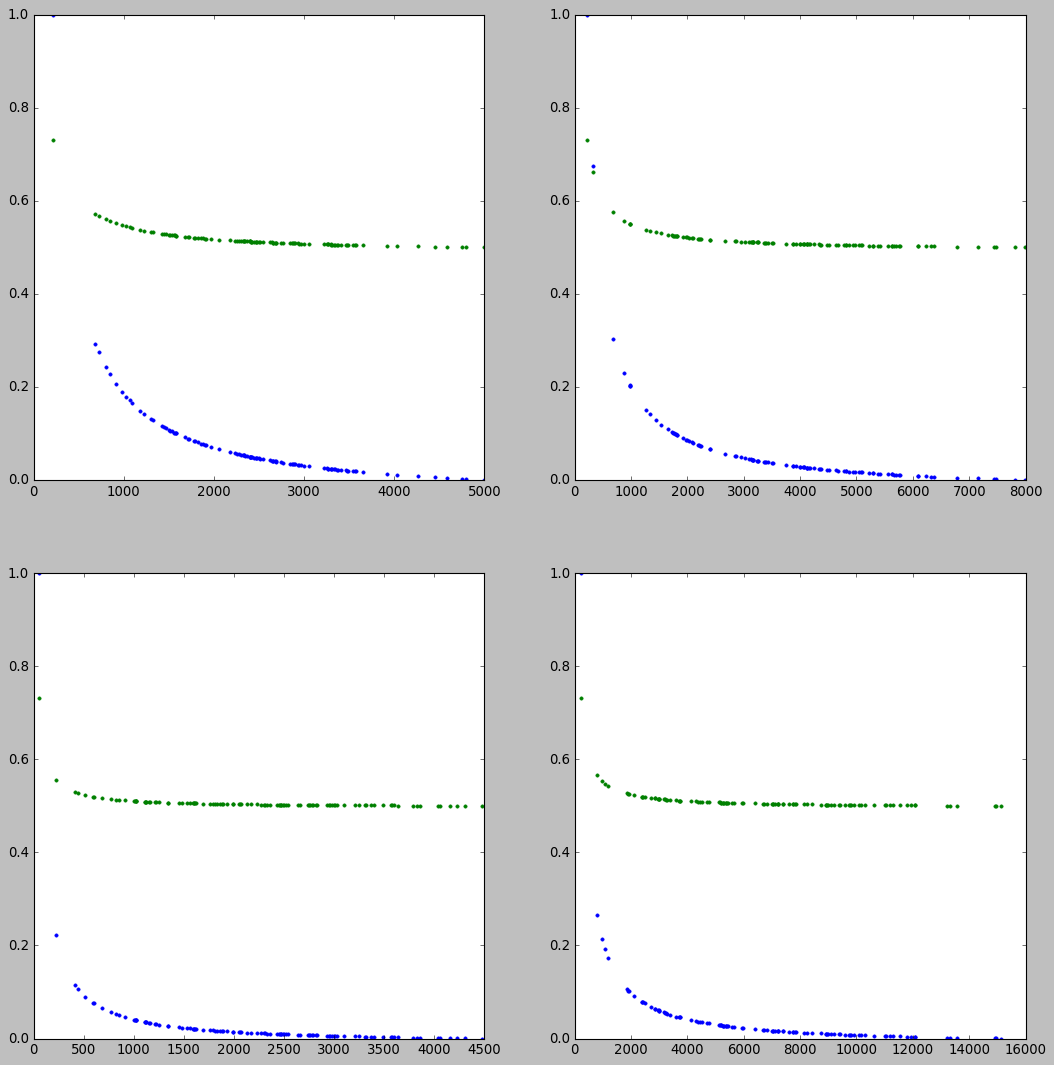

In [88]:
fig = plt.figure(figsize = (16,16))
for i in range(scaled_times.shape[1]):
    fig.add_subplot(2,2,i+1)
    plt.plot(df_travel_new[df_travel_new.columns[i+1]], scaled_times[:,i],'.')
    plt.plot(df_travel_new[df_travel_new.columns[i+1]], sigmoid(scaled_times[:,i]),'.')
    
# we can see that the sigmoid does not have the intended effect... It punishes TOO much
# as such, no special functions will be applied necessarily...
# for the first iteration, it will suffice to just examine all the data together... more elaborate forms of scoring 
# will be implemented later



In [89]:
df_travel_new[['subway','bus','bicycling','walking']] = scaled_times
df_travel_new = df_travel_new.sort_values(by='PostDist')
df_travel_new.head()

,PostDist,subway,bus,bicycling,walking
0,BR1,0.011088,0.023605,0.000000,0.000220
1,CR0,0.066381,0.041312,0.002133,0.003964
7,E1,0.049539,0.024014,0.010534,0.017056
10,E11,0.018578,0.000632,0.001286,0.002036
4,E14,0.040910,0.016578,0.005760,0.009878


In [93]:
for mode in df_travel_new.columns[1:]:
    df_scaled['{}_Metric'.format(mode)] = df_travel_new[mode]
    #df_scaled.insert(1, '{}_Metric'.format(venue), df_venues_new.venue_Metric[df_venues_new.type_major == venue].reset_index().venue_Metric, True)

df_scaled.drop('Unnamed: 0',axis = 1,inplace = True)
df_scaled.tail()

,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic,entertainment_Metric,grocery_Metric,nightlife_Metric,outdoors_Metric,restaurants_Metric,subway_Metric,bus_Metric,bicycling_Metric,walking_Metric
100,WC1N,0.513684,0.230183,0.276582,0.328015,0.458295,0.248238,0.049003,0.409430,0.356685,0.572127,0.290065,0.756044,0.078068,0.048383,0.021247,0.037370
101,WC2A,0.596461,0.039498,0.042094,0.197787,0.458295,0.248238,0.050158,0.429480,0.368171,0.579247,0.297929,0.776182,0.087797,0.073355,0.021185,0.039678
102,WC2B,0.596461,0.235855,0.243931,0.284384,0.458295,0.248238,0.062066,0.447406,0.371140,0.581707,0.312986,0.870548,0.116472,0.101078,0.030196,0.051269
103,WC2E,0.596461,0.222839,0.251367,0.302728,0.458295,0.248238,0.056613,0.440479,0.369910,0.582951,0.306692,0.832931,0.104683,0.074275,0.022672,0.045559
104,WC2H,0.409990,0.169391,0.297346,0.277317,0.458295,0.248238,0.065393,0.443575,0.367915,0.587367,0.313529,0.897185,0.131617,0.081053,0.027357,0.054154


In [195]:
df_final.head()

,PostDist,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place,postdist_distanceMetric
0,BR1,0.003195,0.003802,0.003484,0.002625,0.002008,0.000769,51.415207,0.029229,['Bromley'],0.000059
1,CR0,0.005076,0.003571,0.002817,0.001529,0.001245,0.000769,51.362729,-0.064208,['Croyon'],0.000059
2,E1,0.003058,0.002447,0.001947,0.001254,0.001997,0.000769,51.517623,-0.055755,['Bethnal Green'],0.000116
3,E11,0.003195,0.005780,0.002094,0.001681,0.001245,0.000769,51.572853,0.017635,['Bow'],0.000063
4,E14,0.002921,0.002606,0.002070,0.001684,0.001393,0.000769,51.509750,-0.017595,"['Canary Wharf', 'Isle of Dogs', 'Mudchute']",0.000090


In [196]:
# create a dataframe for recreation!
df_scaled = pd.DataFrame()
df_scaled['PostDist'] = df_travel_new.PostDist.sort_values()
df_final = df_final.sort_values(by=['PostDist'])
df_scaled[['studio_metric',
           'oneBed_metric',
           'twoBed_metric',
           'threeBed_metric',
           'fourBed_metric',
           'fiveBed_metric',
           'distance_Metic'
          ]] = df_final.reset_index()[['Studio',
                                       'One Bed',
                                       'Two Beds',
                                       'Three Beds',
                                       'Four Beds',
                                       'Five Beds',
                                       'postdist_distanceMetric']]

df_scaled[['studio_metric',
           'oneBed_metric',
           'twoBed_metric',
           'threeBed_metric',
           'fourBed_metric',
           'fiveBed_metric',
           'distance_Metic'
          ]] = scaler.fit_transform(np.asarray(
    df_scaled[['studio_metric',
           'oneBed_metric',
           'twoBed_metric',
           'threeBed_metric',
           'fourBed_metric',
           'fiveBed_metric',
           'distance_Metic'
          ]]
))
df_scaled

,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic
0,BR1,0.596461,0.585155,1.000000,0.991403,0.794220,0.248238,0.000729
1,CR0,1.000000,0.536740,0.766740,0.539225,0.458295,0.248238,0.000762
7,E1,0.694007,0.885755,0.807159,0.788151,0.700538,0.248238,0.003324
10,E11,0.596461,0.457771,0.724282,0.766197,0.629475,0.526459,0.010646
4,E14,0.537739,0.334357,0.505839,0.603359,0.523513,0.248238,0.011225
...,...,...,...,...,...,...,...,...
100,WC1N,0.513684,0.230183,0.276582,0.328015,0.458295,0.248238,0.049003
101,WC2A,0.596461,0.039498,0.042094,0.197787,0.458295,0.248238,0.050158
103,WC2B,0.596461,0.235855,0.243931,0.284384,0.458295,0.248238,0.062066
102,WC2E,0.596461,0.222839,0.251367,0.302728,0.458295,0.248238,0.056613


## Score for Venues


In [200]:
df_venues['count'] = 1
df_venues = df_venues.sort_values(by=['postcodes'])
df_venues.head()

,Unnamed: 0,postcodes,names,distance,type_major,type_minor,count
0,0,BR1,EL&N,16270,restaurants,Café,1
151,151,BR1,British Museum,15813,entertainment,History Museum,1
152,152,BR1,Tate Modern,13626,entertainment,Art Museum,1
153,153,BR1,National Gallery,15111,entertainment,Art Museum,1
154,154,BR1,Tower of London,12680,entertainment,Castle,1


In [201]:
df_grouped_mean = df_venues.copy()
df_grouped_mean.drop(['Unnamed: 0','names','type_minor','count'],axis = 1,inplace = True)
df_grouped_mean = df_grouped_mean.groupby(['postcodes','type_major']).mean()
print(df_grouped_mean.shape)
df_grouped_mean.head()

(525, 1)


distance
postcodes type_major                 
BR1       entertainment  15824.140000
          grocery        16076.140000
          nightlife      16210.620000
          outdoors       16766.540541
          restaurants    16453.920000

In [202]:
df_grouped_sum = df_venues.copy()
df_grouped_sum.drop(['Unnamed: 0','names','type_minor','distance'],axis = 1,inplace = True)
df_grouped_sum = df_grouped_sum.groupby(['postcodes','type_major']).sum()
print(df_grouped_sum.shape)


df_grouped_sum.head()

(525, 1)


count
postcodes type_major          
BR1       entertainment     50
          grocery           50
          nightlife         50
          outdoors          37
          restaurants       50

Note on analysis: I made a mistake in not setting a radius when searching for venues... 
Because this way, we now have almost 50 venues for each category in each location... so it kind of defeats the purpose of the analysis in a way!

In [203]:
df_venues_new = pd.concat([df_grouped_sum,df_grouped_mean],axis =1 )
df_venues_new['venue_Metric'] = df_venues_new['count'] / df_venues_new.distance

df_venues_new.head()

count      distance  venue_Metric
postcodes type_major                                      
BR1       entertainment     50  15824.140000      0.003160
          grocery           50  16076.140000      0.003110
          nightlife         50  16210.620000      0.003084
          outdoors          37  16766.540541      0.002207
          restaurants       50  16453.920000      0.003039

In [204]:
# combine all the metrics in the final dataset
df_venues_new.venue_Metric = scaler.fit_transform(np.asarray(df_venues_new.venue_Metric).reshape(-1,1))
df_venues_new.reset_index(inplace = True)

for venue in df_venues_new.type_major.unique():
    df_scaled['{}_Metric'.format(venue)] = df_venues_new.venue_Metric[df_venues_new.type_major == venue].reset_index().venue_Metric
    #df_scaled.insert(1, '{}_Metric'.format(venue), df_venues_new.venue_Metric[df_venues_new.type_major == venue].reset_index().venue_Metric, True)


    
df_scaled

,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic,entertainment_Metric,grocery_Metric,nightlife_Metric,outdoors_Metric,restaurants_Metric
0,BR1,0.596461,0.585155,1.000000,0.991403,0.794220,0.248238,0.000729,0.088186,0.084387,0.082408,0.015096,0.078910
1,CR0,1.000000,0.536740,0.766740,0.539225,0.458295,0.248238,0.000762,0.062354,0.056126,0.053803,0.000000,0.062208
7,E1,0.694007,0.885755,0.807159,0.788151,0.700538,0.248238,0.003324,0.125615,0.128632,0.165040,0.058260,0.158189
10,E11,0.596461,0.457771,0.724282,0.766197,0.629475,0.526459,0.010646,0.246091,0.233379,0.299732,0.126066,0.274391
4,E14,0.537739,0.334357,0.505839,0.603359,0.523513,0.248238,0.011225,0.259460,0.241469,0.290095,0.123615,0.274961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,WC1N,0.513684,0.230183,0.276582,0.328015,0.458295,0.248238,0.049003,0.409430,0.356685,0.572127,0.290065,0.756044
101,WC2A,0.596461,0.039498,0.042094,0.197787,0.458295,0.248238,0.050158,0.429480,0.368171,0.579247,0.297929,0.776182
103,WC2B,0.596461,0.235855,0.243931,0.284384,0.458295,0.248238,0.062066,0.447406,0.371140,0.581707,0.312986,0.870548
102,WC2E,0.596461,0.222839,0.251367,0.302728,0.458295,0.248238,0.056613,0.440479,0.369910,0.582951,0.306692,0.832931


In [94]:
df_scaled.to_csv('../Data/dataframes/df_scaled.csv')

In [95]:
df_scaled = pd.read_csv('../Data/dataframes/df_scaled.csv')

In [97]:
df_scaled.head()

,Unnamed: 0,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic,entertainment_Metric,grocery_Metric,nightlife_Metric,outdoors_Metric,restaurants_Metric,subway_Metric,bus_Metric,bicycling_Metric,walking_Metric
0,0,BR1,0.596461,0.585155,1.000000,0.991403,0.794220,0.248238,0.000729,0.088186,0.084387,0.082408,0.015096,0.078910,0.011088,0.023605,0.000000,0.000220
1,1,CR0,1.000000,0.536740,0.766740,0.539225,0.458295,0.248238,0.000762,0.062354,0.056126,0.053803,0.000000,0.062208,0.066381,0.041312,0.002133,0.003964
2,2,E1,0.694007,0.885755,0.807159,0.788151,0.700538,0.248238,0.003324,0.125615,0.128632,0.165040,0.058260,0.158189,0.040064,0.016277,0.008986,0.016231
3,3,E11,0.596461,0.457771,0.724282,0.766197,0.629475,0.526459,0.010646,0.246091,0.233379,0.299732,0.126066,0.274391,0.039743,0.014512,0.007138,0.010162
4,4,E14,0.537739,0.334357,0.505839,0.603359,0.523513,0.248238,0.011225,0.259460,0.241469,0.290095,0.123615,0.274961,0.040910,0.016578,0.005760,0.009878


In [101]:
path = "../Data/json/london_geodata.json"


m = folium.Map(location=[51.509865,-0.118092], zoom_start=10,  tiles = 'CartoDB positron')

m.choropleth(
    geo_data=path,
    data=df_scaled,
    columns=['PostDist', 'studio_metric'],
    key_on='feature.properties.Name',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='studio_metric',
    smooth_factor=0)


geolocator = GoogleV3(config['google']['key'])
lat_long = get_lat_long(geolocator, 'Imperial College London')
folium.Marker(
    location = lat_long,
    icon=folium.Icon(color = 'lightgray',icon_color='#002147',prefix='fa',icon='university'),
    popup= 'Imperial College London'
).add_to(m)

m

Notes: it does not seem like our data has been processed correctly...? 
There is something off, because when you look at the walking scores you get values that you don't expect at all...
Based on the choropleth map, you get a very uniform map... where some of the locations very far from uni actually have good distances...

This could be because of the fact that you've done a reciprocal ?

In [104]:
# explore the above problem

df_temp_2 = df_scaled[['PostDist','distance_Metic']]
df_temp_2.sort_values(by='distance_Metic')

# a) we have NaN values... that is very weird
# b) My theory was right... it seems that the distance reciprocal did not work too great.
# THAT said, since this is the first iteration I will continue with this, and see where we get to

,PostDist,distance_Metic
56,SE9,0.000000
46,SE17,0.000190
0,BR1,0.000729
1,CR0,0.000762
10,E3,0.002241
...,...,...
63,SW15,0.232738
71,SW1W,0.249249
82,W1,0.303552
64,SW16,1.000000


# Clustering Neighborhoods


In [106]:
df_scaled.head()

,Unnamed: 0,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic,entertainment_Metric,grocery_Metric,nightlife_Metric,outdoors_Metric,restaurants_Metric,subway_Metric,bus_Metric,bicycling_Metric,walking_Metric
0,0,BR1,0.596461,0.585155,1.000000,0.991403,0.794220,0.248238,0.000729,0.088186,0.084387,0.082408,0.015096,0.078910,0.011088,0.023605,0.000000,0.000220
1,1,CR0,1.000000,0.536740,0.766740,0.539225,0.458295,0.248238,0.000762,0.062354,0.056126,0.053803,0.000000,0.062208,0.066381,0.041312,0.002133,0.003964
2,2,E1,0.694007,0.885755,0.807159,0.788151,0.700538,0.248238,0.003324,0.125615,0.128632,0.165040,0.058260,0.158189,0.040064,0.016277,0.008986,0.016231
3,3,E11,0.596461,0.457771,0.724282,0.766197,0.629475,0.526459,0.010646,0.246091,0.233379,0.299732,0.126066,0.274391,0.039743,0.014512,0.007138,0.010162
4,4,E14,0.537739,0.334357,0.505839,0.603359,0.523513,0.248238,0.011225,0.259460,0.241469,0.290095,0.123615,0.274961,0.040910,0.016578,0.005760,0.009878


In [113]:
df_cluster = df_scaled.copy()
df_cluster.dropna(inplace = True)
X = np.asarray(df_cluster[df_cluster.columns[2:]])

In [114]:

model = KMeans()

y_hat = model.fit_predict(X)
y_hat

array([7, 0, 0, 4, 5, 5, 7, 5, 5, 5, 4, 4, 5, 1, 4, 1, 5, 4, 5, 4, 5, 0,
       4, 1, 4, 0, 2, 2, 0, 4, 5, 5, 4, 4, 4, 4, 5, 2, 5, 0, 0, 7, 4, 4,
       0, 4, 4, 5, 4, 7, 7, 0, 7, 0, 5, 4, 6, 4, 2, 5, 0, 6, 6, 6, 5, 4,
       4, 4, 2, 3, 2, 0, 4, 1, 1, 4, 6, 4, 4, 4, 4, 6, 2, 2, 1, 2, 1, 4,
       2, 1, 0, 5, 5, 6, 6, 1, 4, 1, 1, 1, 1, 1, 1], dtype=int32)

In [115]:
df_cluster['scores'] = y_hat
df_cluster.head()

,Unnamed: 0,PostDist,studio_metric,oneBed_metric,twoBed_metric,threeBed_metric,fourBed_metric,fiveBed_metric,distance_Metic,entertainment_Metric,grocery_Metric,nightlife_Metric,outdoors_Metric,restaurants_Metric,subway_Metric,bus_Metric,bicycling_Metric,walking_Metric,scores
0,0,BR1,0.596461,0.585155,1.000000,0.991403,0.794220,0.248238,0.000729,0.088186,0.084387,0.082408,0.015096,0.078910,0.011088,0.023605,0.000000,0.000220,7
1,1,CR0,1.000000,0.536740,0.766740,0.539225,0.458295,0.248238,0.000762,0.062354,0.056126,0.053803,0.000000,0.062208,0.066381,0.041312,0.002133,0.003964,0
2,2,E1,0.694007,0.885755,0.807159,0.788151,0.700538,0.248238,0.003324,0.125615,0.128632,0.165040,0.058260,0.158189,0.040064,0.016277,0.008986,0.016231,0
3,3,E11,0.596461,0.457771,0.724282,0.766197,0.629475,0.526459,0.010646,0.246091,0.233379,0.299732,0.126066,0.274391,0.039743,0.014512,0.007138,0.010162,4
4,4,E14,0.537739,0.334357,0.505839,0.603359,0.523513,0.248238,0.011225,0.259460,0.241469,0.290095,0.123615,0.274961,0.040910,0.016578,0.005760,0.009878,5


In [118]:
path = "../Data/json/london_geodata.json"


m = folium.Map(location=[51.509865,-0.118092], zoom_start=10,  tiles = 'CartoDB positron')

m.choropleth(
    geo_data=path,
    data=df_cluster,
    columns=['PostDist', 'scores'],
    key_on='feature.properties.Name',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='clusters',
    smooth_factor=0)


geolocator = GoogleV3(config['google']['key'])
lat_long = get_lat_long(geolocator, 'Imperial College London')
folium.Marker(
    location = lat_long,
    icon=folium.Icon(color = 'lightgray',icon_color='#002147',prefix='fa',icon='university'),
    popup= 'Imperial College London'
).add_to(m)

m

# Conclusion

# References

1. https://stackoverflow.com/questions/45992235/foursquare-api-get-filtered-list-of-restaurants
2. https://developer.foursquare.com/docs/build-with-foursquare/categories/
3. https://github.com/sjwhitworth/london_geojson/blob/master/london_postcodes.json


